In [1]:
import os
import tarfile
import urllib
from zlib import crc32

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

Neste notebook, trabalharemos em um projeto de Machine Learning de ponta a ponta para uma empresa do ramo imobiliário.

### 1. Frame the problem
- Entenda o objetivo do negócio. 
- Criar um modelo não deve ser o objetivo final. 
- Como a empresa vai usar esse modelo?

    Nosso chefe disse que deseja obter a mediana do preço habitacional de um distrito dado e usá-lo em outro sistema de Machine Learning com outros sinais, que deverá classificar um distrito como interessante para investir ou não.

![frame_the_problem](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0202.png)

- Como o problema é resolvido atualmente? (Caso seja) A resposta vai nos dar referências da performance atual e, talvez, insights de como resolver o problema.
    O chefe responde que a estimativa atual é feita por experts, mas é cara, toma muito tempo e muitas vezes as estimativas têm erro superior a 20%.
- É supervised, unsupervised ou reinforcement learning?
- É um problema de classificação, regressão, ou outro?
- É um problema para aprendizagem online ou em batch?

    Este é um problema de regressão de aprendizagem supervisionada e em batch.
    
#### 1.2. Select a performance measure
Para regressão, a Root Mean Square Error é geralmente usada como métrica de performance.


### 2. Gather Data

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

HOUSING_PATH = os.path.join(os.pardir, os.pardir, "data", "housing")

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [ ]:
# Fetch and download housing data
fetch_housing_data()

# Load and print housing data
housing = load_housing_data()
housing.head()

In [55]:
housing = pd.read_csv("C:\\Users\\itolivei\\Desktop\\housing.txt")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [56]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [57]:
# Ocean proximity is a text or is a category?
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [58]:
housing.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


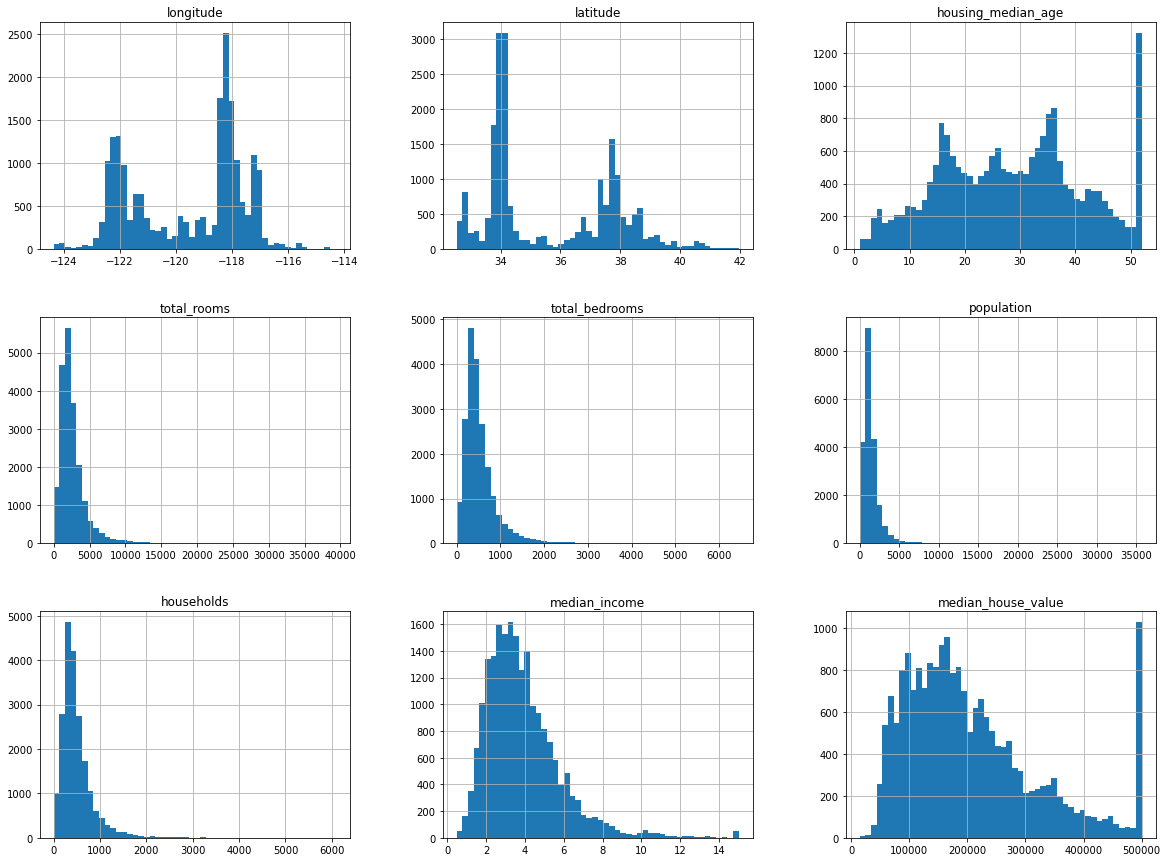

In [59]:
housing.hist(bins=50, figsize=(20, 15));

1. A feature `median_income` não parece correta. Após checar com a fonte dos dados, vimos que esse número estar em dezenas de milhares milhares, mas que os valores maiores foram aparados (capped) para 15.0001 (150,000) e os menores para 0.4999
2. As features `housing_median_age` e `median_house_value` parecem ter passado por um tratamento de outliers também. O capped de `median_house_value` preocupa pois é nossa variável target, precisamos checar com os clientes se eles precisam de predições para valores acima de 500,000 dollars. De acordo com as respostas deles, temos 2 opções:
    - a) Coletar os valores reais para os distritos que tiveram o `target` aparado.
    - b) Remover esses distritos.
3. Os atributos têm escalas muito diferentes.
4. Muitos histogramas com right heavy skewed. Isso pode ser dificultar a percepção de padrões para alguns algoritmos de Machine Learning.

### 3. Create a test set
Antes de fazer qualquer análise mais profunda, vamos dividir a parcela dos dados que não mais olharemos e servirá para avaliar nossos modelos futuramente.

Pode parecer estranha a ideia de não mais olharmos o set de test, mas nosso cérebro é ótimo em identificar padrões. Portanto, olhar essa parcela de teste pode nos induzir a usar um modelo de Machine Learning que será ótimo para o test set, e isso se refletirá nas métricas, mas, quando for posto em produção, possivelmente veremos que ele não está tão bom quanto esperávamos ao generalizar.

In [60]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

In [61]:
train_set, test_set = split_train_test(housing, 0.2)

train_set.shape, test_set.shape

((16512, 10), (4128, 10))

Apesar desse split funcionar, ele não é perfeito porque se o notebook rodar novamente, teremos conjuntos de treino e de test diferentes. Com o tempo, o modelo já terá rodado com todo o dataset, e não queremos isso.

Possíveis soluções de imediato:
- Salvar o conjunto de teste na primeira vez que rodar e recarregá-lo futuramente.
- Configurar a random seed antes de chamar np.random.permutation()

Mas ainda teremos um problema caso o dataset seja atualizado. Para ter conjuntos de treino e teste estáveis mesmo após update do dataset, uma solução é usar o identificador único de cada caso para decidir se ele vai ou nao para o conjunto de teste.

In [62]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    
    return data.loc[~in_test_set], data.loc[in_test_set]

In [63]:
housing_with_id = housing.reset_index()
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [64]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

Todos esses métodos se tratam de amostragem aleatória simples. Se o dataset original for grande o suficiente, esse tipo de amostragem estará geralmente okay. Caso contrário, poderemos estar introduzindo sampling bias.

Após conversar com especialistas que fazem a inferência atualmente, eles disseram que `median_income` é um atributo bastante importante para inferir a nossa variável target `median_housing_prices`. Portanto, precisamos garantir que o test set é representativo das várias range de `median_income` do dataset inteiro.

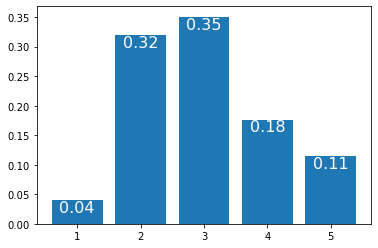

In [65]:
bins = [0., 1.5, 3.0, 4.5, 6., np.inf]
labels = [1, 2, 3, 4, 5]

housing["income_cat"] = pd.cut(housing["median_income"], bins=bins, labels=labels)

# Plotting proportions of districts in each category of median income
prop_inc_cat = housing["income_cat"].value_counts(normalize=True).sort_index()

plt.bar(prop_inc_cat.index, prop_inc_cat.values)

for a, b in zip(prop_inc_cat.index, prop_inc_cat.values):
    plt.text(a, b, np.round(b, 2), ha="center", va="top", color="white", fontsize=16)

In [87]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_index, test_index = list(split.split(housing, housing["income_cat"]))[0]

strat_train_set = housing.loc[train_index]
strat_test_set = housing.loc[test_index]

In [90]:
np.round(strat_test_set["income_cat"].value_counts(normalize=True).sort_index(), 2)

1    0.04
2    0.32
3    0.35
4    0.18
5    0.11
Name: income_cat, dtype: float64

In [91]:
strat_train_set.shape, strat_test_set.shape

((16512, 11), (4128, 11))

In [92]:
# Dropping income_cat from attributes
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True, errors="ignore")

### 4. Discover and visualize the data to gain insights

In [93]:
# Putting test set apart
housing = strat_train_set.copy()

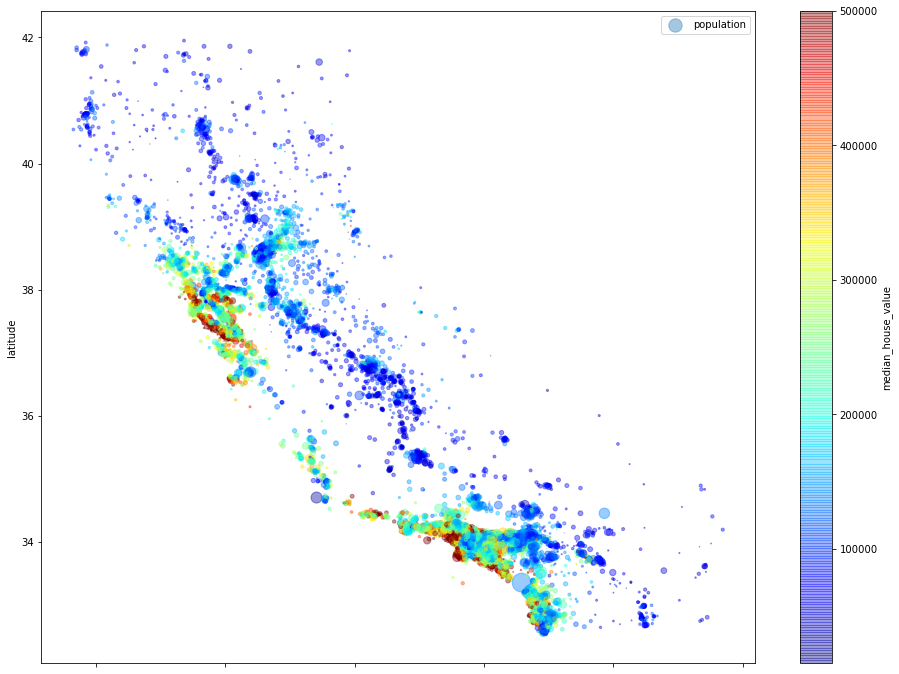

In [94]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(16, 12),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend();

O gráfico nos mostra que o preço da habitação é muito relacionado à localidade e à densidade populacional.

Um algoritmo de clustering pode ser útil, pois, a partir dos clusters, podemos criar novas features que medem a proximidade aos centroids dos clusters.

Além disso, vemos que a proximidade ao mar é um atributos que será bastante importante na inferência, apesar de que existem regiões próximas ao mar que não são tão caras, portanto não se trata de uma regra simples.

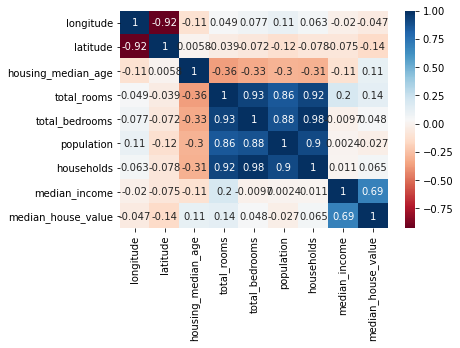

In [95]:
corr_matrix = housing.corr()

sns.heatmap(corr_matrix, cmap="RdBu", annot=True);

Podemos estar deixando de ver correlações não lineares com essa matriz

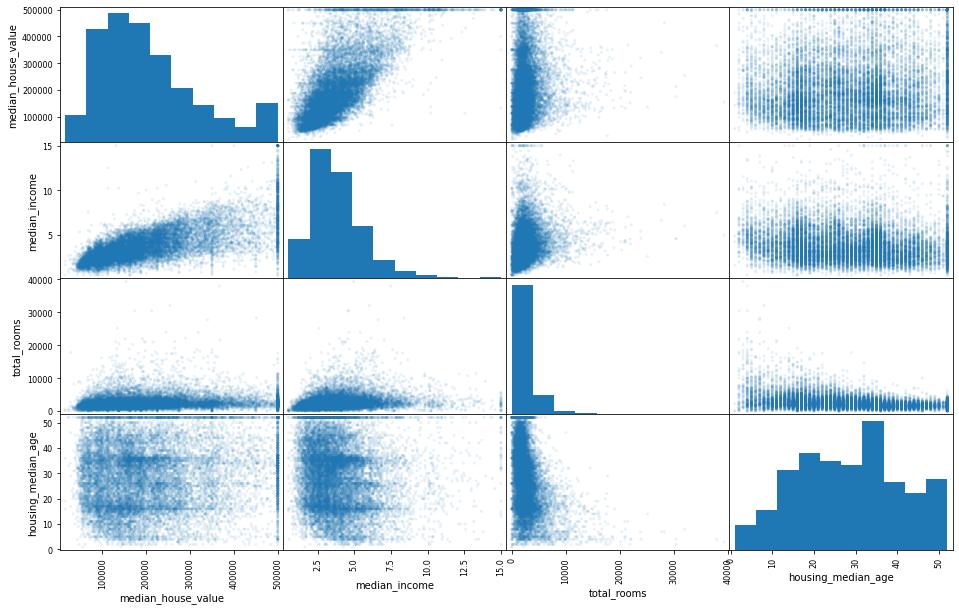

In [96]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix(housing[attributes], alpha=.1, figsize=(16, 10));

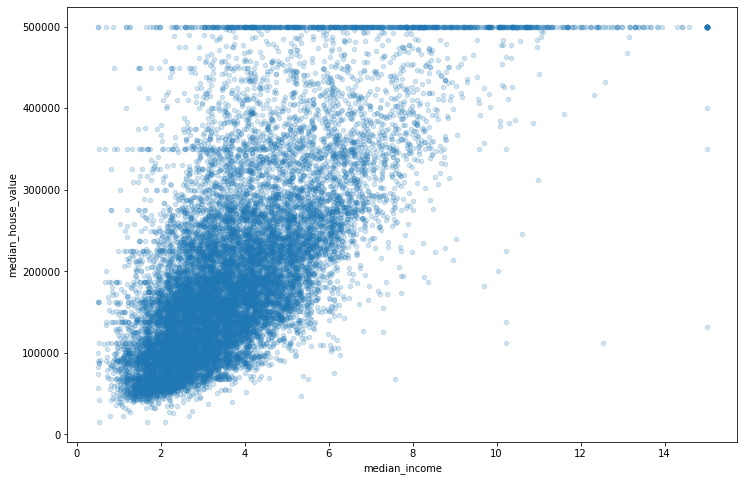

In [97]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.2, figsize=(12, 8))

#### 4.2. Experimentation with attribute combinations

In [98]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [99]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Essa etapa de exploração dos dados não precisa ser absolutamente completa.
O ponto aqui é começar com o pé direito e ganhar insights rápidos de como conseguir um primeiro protótipo razoavelmente bom.
Mas, por se tratar de um processo iterativo, uma vez que prototipamos o primeiro modelo, podemos analisar o output e conseguir mais insights para voltar a esse passo de exploração.

### 5. Prepare the data for Machine Learning Algorithms

É hora de preparar os dados para os algoritmos de Machine Learning. Ao invés de fazer isso manualmente, você deve escrever funções por vários bons motivos:
1. Permite a reprodutibilidade dessas transformações em qualquer dataset.
2. Você gradualmente irá construir uma biblioteca de funções de transformação que poderão ser reutilziadas em projetos futuros.
3. Você pode usar essas funções no sistema em produção para transformar novos dados antes de alimentar o modelo.
4. Tornará possível tentar várias transformações e ver quais combinações de transformações funcionam melhor.

#### 5.1 Handling Null values

In [100]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

A maioria dos algoritmos de Machine Learning não sabe lidar com valores nulos, vimos que existem distritos onde total_bedrooms está nulo.
Temos 3 opções:
1. Dropar esses distritos.
2. Dropar o atributo inteiro.
3. Atribuir valores.

In [101]:
housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

In [102]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [103]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [104]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [105]:
X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

#### 5.2 Handling text and categorical attributes

A maioria dos algoritmos de ML prefere trabalhar com números, então vamos converter as categorias de texto para números.

In [106]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


##### 5.2.1. Ordinal Encoder

In [107]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [108]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

##### 5.2.2. One-hot Encoder
O problema do Ordinal Encoder é que o MachineLearning vai assumir que dois valores próximos são mais similares do que valores distantes. Essa abordagem é ótima para categorias ordenadas como "ótimo", "bom", "mais ou menos" e "ruim", mas esse não é o nosso caso.

Uma solução comum é criar um atributo binário para cada categoria. Isso se chama **one-hot encoding**.

In [109]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [110]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [111]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#### TIP
Caso o atributo categórico tenha muitas categorias, o resultado do one-hot encoding será muitas features. Isso pode atrapalhar a performance do treinamento. Se isso acontecer, você poderia trocar a categoria por features numéricas relacionadas às categorias. Por exemplo, poderíamos trocar ocean_proximity pela distância ao oceano.

#### 5.3 Custom transformers

Apesar do Scikit-Learn fornecer muitos transformadores úteis, você precisará escrever alguns para tarefas como operações de limpeza ou combinação de atributos específicos. 

Vamos querer que nosso transformador trabalhe perfeitamente com funcionalidades do Scikit-Learn (como pipelines), portanto, tudo que precisamos fazer é criar classes que implementem três métodos:
- fit() 
- transform()
- fit_transform()

Nós conseguimos o último facilmente adicionando o TransformerMixin como uma classe base. Se você adicionar BaseEstimator como uma classe, você também receberá dois métodos extras (get_params() e set_params()) que serão úteis para o tuning automático dos hyperparâmetros.

In [112]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN


In [113]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]


attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
housing_extra_attribs = attr_adder.fit_transform(housing.values)

#### 5.4. Feature Scaling

Uma das transformações mais importantes a se aplicar nos dados é a feature scaling. Com poucas exceções, algoritmos de ML não performam bem quando os inputs estão em escalas muito diferentes.

Existem duas formas comuns de jogar todos os atributos na mesma escala:
- **Min-max Scaling**: Muitas vezes chamado de normalização. Os valores são re-escalados para que passem a variar entre 0 e 1
    
- **Standardization**: Subtrai dos valores a média do vetor (assim, passaremos a ter média 0) e divide pelo standard deviation. Diferente do Min-max Scaling, não limita os valores a um intervalo específico, o que pode ser problema para alguns algoritmos (redes neurais que esperam por valores entre 0 e 1). A vantagem deste, é que é muito menos afetado por outliers.

#### WARNING
Como em todas as transformações, é importante ajustar os re-escaladores apenas ao conjunto de treino e depois aplicar ao conjunto de teste e aos novos dados.

#### 5.5. Transformation Pipelines

In [114]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

O método construtor do Pipeline pega uma lista com os pares nome + estimator definindo uma sequência de passos. Todos, exceto o último estimator, devem ser transformers (eles devem ter o método fit_transform()). Os nome podem ser qualquer um que você queira.

Até agora, nós lidamos com as colunas categóricas e colunas numéricas separadamente. Seria mais conveniente ter um único transforme capaz de lidar com todas as colunas, aplicando as transformações apropriadas para cada coluna. 


In [115]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

#### TIP
Ao invés de usar um transformer, você pode especificar a string "drop" para dropar colunas, ou "passthrough" se você quiser deixar algumas colunas intocadas. Por default, as colunas restantes serão dropadas.

In [150]:
housing_prepared.shape

(16512, 16)

### 6. Select and Train a Model

Enfim, entendemos o problema, conseguimos os dados e o exploramos, dividimos os conjuntos de treino e teste, e escrevemos algumas pipelines de transformação para limpeza e preparação dos dados. Estamos prontos para selecionar treinar o algoritmo de ML.

#### 6.1. Training and Evaluating on the Training Set

In [152]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [153]:
housing.iloc[:3]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN


In [154]:
some_data = housing.iloc[:3]
some_labels = housing_labels.iloc[:3]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", np.round(lin_reg.predict(some_data_prepared)))
print("Labels:", list(some_labels))

Predictions: [210645. 317769. 210956.]
Labels: [286600.0, 340600.0, 196900.0]


In [155]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)

lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.round(np.sqrt(lin_mse), 2)
lin_rmse

68628.2

O modelo é melhor que nada, mas o score não está bom.

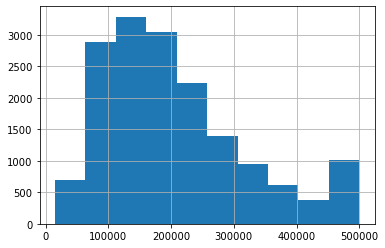

In [156]:
housing_labels.hist();

#### Underfitting
Esse é um exemplo de um modelo que está `underfitting` os dados de treinamento. Quando isso acontece, isso pode significar:
- As features não provêm informação suficiente para fazer predições
- O modelo não é poderoso o suficiente

Dentre as principais formas de corrigir underfitting temos:
- Selecionar modelos mais poderosos
- Alimentar o algoritmo de treino com features melhores
- Eliminar restrições (como regularizações)

A princípio, vamos tentar um modelo mais complexo.

In [158]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

#### Overfitting
Neste caso, o modelo poderia estar absolutamente perfeito, mas é muito mais provável que o modelo esteja `overfitting`. 

O ideal é não tocar no conjunto de teste antes de ter um modelo pronto para ser posto em produção, então, precisaremos usar parte do conjunto de treinamento para treino e parte para validação do modelo.

#### 6.2. Better Evaluation Using Cross-Validation
Uma forma de avaliar o modelo de Decision Tree seria usar o train_test_split() para dividir o conjunto de treino em um conjunto menor de treinamento + um conjunto de validação, então, treinar os modelos com o conjunto menor de treinamento  e avaliar ele com o conjunto de validação.

Uma ótima alternativa é usar K-fold Cross-Validation. O código a seguir divide o conjunto de treino em 10 sub-conjuntos distintos e os chama de folds, então treina e avalia o modelo de Decision Tree 10 vezes, usando, a cada iteração, um fold para avaliação e os 9 restantes para treino. O resultado é um vetor contendo 10 scores de avaliação.

In [159]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.round(np.sqrt(-scores))

#### WARNING

**O Cross-Validation do Scikit-Learn espera uma `utility function` (maior é melhor) ao invés de uma `cost function` (maior é pior), então a scoring function deve ser o oposto de MSE, que é o motivo pelo qual os códigos a seguir computam scores negativos antes de calcular a raiz quadrada**

In [160]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    

display_scores(tree_rmse_scores)

Scores: [68924. 67581. 71972. 68313. 71311. 74547. 71566. 71953. 76774. 70336.]
Mean: 71327.7
Standard deviation: 2660.3887704619415


Agora, a Decision Tree não parece boa como antes. Ela parece ter performance pior que a Linear Regression.

Veja que o cross-validation permite que vejamos não apenas a estimativa de performance do modelo, mas também a medida de quão precisa a estimativa é, isto é, seu desvio padrão.

A Decision Tree tem o score de aproximadamente 70,876, geralmente +- 2,894. Não teríamos essa informação apenas usando um conjunto de validação. Mas o cross validation tem o custo de treinar o modelo várias vezes, então nem sempre será possível.

Vamos calcular esses scores também para a Linear Regression.

In [161]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983498


Correto, a Decision Tree está `overfitting` tanto que está pior que a Regressão Linear.

Vamos tentar um último modelo: o RandomForestRegressor. RandomForests funcionam treinando várias DecisionTrees em subconjuntos aleatórios de features e o output é a média das inferências de cada DecisionTree.

Construir um modelo sobre muitos outros modelos é chamado de **Ensemble Learning** e é frequentemente uma ótima maneira de levar os algoritmos de ML mais adiante.

In [162]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

18695.986746958206


In [106]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [49370.72324882 47491.16745287 50224.22013341 52054.14739591
 49415.22381397 53383.15769981 48774.98293618 47958.40176352
 53224.24010292 50004.89985403]
Mean: 50190.116440144484
Standard deviation: 1960.8886043960536


As coisas estão melhores: RandomForests parecem promissoras.

Entretanto, veja que os scores no conjunto de treino continua muito menor que os scores nos conjuntos de validação, significando que o modelo continua `overfitting` o conjunto de treino.

Soluções possíveis são:
- Simplificar o modelo
- Adicionar regularizações
- Conseguir mais dados

Antes de mergulhar em Random Forest, entretanto, devemos tentar muitos outros modelos de categorias diferentes de Machine Learning (Support Vector Machines com kernels diferentes, Redes Neurais), sem gastar muito tempo brincando com os hyperparemeters. O objetivo é ter uma pequena lista (de 2 a 5) modelos promissores.

#### TIP
Devemos salvar cada model que experimentamos para caso queiramos retornar a qualquer um deles no futuro. Garanta que salvou:
- Hiperparâmetros
- Scores do Cross-Validation
- Predictions

Isso permite fácil comparação de scores entre tipos de modelos, e comparar tipos de erros que eles cometem.

```
import joblib

joblib.dump(my_model, "my_model.pkl")

my_model_loaded = joblib.load("my_model.pkl")
```


### 7. Fine-Tune Your Model
Vamos assumir que temos uma lista pequena de modelos promissores. Agora precisamos aprimorá-los. Vamos ver algumas formas de fazer isso.

#### 7.1. Grid Search

In [165]:
from sklearn.model_selection import GridSearchCV

# 18 possible combinations
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

#### TIP
Se não tem ideia de qual hyperparameter tentar, uma abordagem simples é tentar potências de 10 consecutivas: 
- 0.001, 0.01, 0.1, 1, 10, 100

In [183]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

#### TIP
Como 8 e 30 são os valores máximos para as combinações que demos, poderíamos tentar buscar novamente com combinações de valores mais altos, o score pode continuar a melhorar.

In [184]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

#### NOTE
Se o GridSearchCV foi instanciado com refit=True (default), então quando ele encontra o melhor estimator usando cross-validation, ele retreina esse modelo no conjunto de treinamento inteiro (sem considerar conjunto de validação).

Isto é geralmente uma boa ideia, já que alimentar o modelo com mais dados provavelmente melhorá sua performance.

In [185]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("Score: {:<25,} Params: {}".format(np.round(np.sqrt(-mean_score), 1), params))

Score: 64,636.2                  Params: {'max_features': 2, 'n_estimators': 3}
Score: 55,727.6                  Params: {'max_features': 2, 'n_estimators': 10}
Score: 52,861.6                  Params: {'max_features': 2, 'n_estimators': 30}
Score: 61,119.6                  Params: {'max_features': 4, 'n_estimators': 3}
Score: 52,567.7                  Params: {'max_features': 4, 'n_estimators': 10}
Score: 50,727.3                  Params: {'max_features': 4, 'n_estimators': 30}
Score: 58,936.3                  Params: {'max_features': 6, 'n_estimators': 3}
Score: 52,331.1                  Params: {'max_features': 6, 'n_estimators': 10}
Score: 50,109.4                  Params: {'max_features': 6, 'n_estimators': 30}
Score: 59,129.9                  Params: {'max_features': 8, 'n_estimators': 3}
Score: 52,116.0                  Params: {'max_features': 8, 'n_estimators': 10}
Score: 49,996.6                  Params: {'max_features': 8, 'n_estimators': 30}
Score: 62,686.4                 

Neste exemplo, nós obtivemos a melhor solução na configuração de max_feature=8 e n_estimators=30.

O RMSE para essa combina~çao é 49,682, que é um pouco melhor que aquele que conseguimos usando os hiperparâmetros default.

#### TIP
Não esqueça que podemos tratar alguns passos de preprocessamento de dados como hiperparâmetros.

Por exemplo, a Grid Search vai descobrir automaticamente se vale a pena ou não inserir features que você não tem tanta certeza se deve. Por exemplo, usar add_bedrooms_per_room=True ou False. Ele pode ser usado de forma similar para encontrar automaticamente a melhor forma de lidar com outliers, valores nulos, seleção de features, e mais.

#### 7.2. Randomized Search
A abordagem da GridSearch é ótima quando você está explorando poucas combinações, mas quando a busca é grande, é frequentemente preferível usar RandomizedSearchCV. Essa classe pode ser usada de forma muito parecido à classe GridSearchCV, mas ao invés de tentar todas as combinações dadas, ele tenta um número dado de combinações aleatórias. Essa abordagem tem dois benefícios principais:
- Se você ordenar que ele itere 1,000 vezes, ele explorará 1,000 combinações diferentes.
- Temos mais controle de quanto poder computacional desejamos alocar à buscar de hyperparâmetros ótimos.

In [194]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(20, 200000),
    'gamma': expon(scale=1.0),
}

svm_reg = SVR()
rnd_search = RandomizedSearchCV(
    svm_reg, 
    param_distributions=param_distribs, 
    n_iter=50, 
    cv=5, 
    scoring='neg_mean_squared_error',
    verbose=2, 
    random_state=42
)

rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  12.5s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  15.0s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  13.1s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  13.6s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  12.5s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  21.8s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  23.8s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......


KeyboardInterrupt: 

#### 7.3. Ensemble Methods
Uma outra forma de aprimorar o sistema é tentar combinações de modelos que melhor performam. O Ensemble geralmene performará melhor que o melhor modelo individual.


### 8. Analyze the Best Models and Their Errors
Você irá ter bons insights do problema inspecionando os melhores modelos.

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

Com essa informação, podemos tentar dropar algumas features menos importates. 

Aparentemente, apenas uma categoria de ocean_proximity é realmente útil, então poderiamos tentar dropar as outras.

Devemos também observar erros específicos que o sistema faz, e tentar entender o porquê dele e o que poderia resolver o problema.

### 9. Evaluate Your System on the Test Set
Após ajustar os modelos, nós teremos um sistema com performance suficiente boa. Agora é hora de avaliar o modelo final no conjunto de teste.

In [195]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48382.59694261304

Uma estimativa pontual não é o suficiente. Damos essa medida, então, em um intervalo de confiança de 95% seguindo a distribuição t-Student

In [215]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2

np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([46340.90682903, 50341.55071197])

In [333]:
#########################
## Ignorar esta célula ##
#########################

confidence = .95
pct_errors = 1 - (final_predictions / y_test)

thrs = np.round(stats.t.interval(confidence, len(pct_errors) - 1, loc=pct_errors.mean(), scale=stats.sem(pct_errors)), 3)
thrs
# plt.hist(pct_errors, bins=500)
# for thr in thrs:
#     plt.axvline(thr, color="orange")
# plt.xlim(0, 1);

array([-0.088, -0.063])

A performance será geralmente um pouco pior daquela observada usando cross-vlaidation, afinal, o sistema final foi aprimorado para performar bem nos dados de validação e provavelmente não irá performar tão bem em dados desconhecidos. 

Quando isso acontece, devemos ser resistentes à tentação de ajustar hiperparâmetros para melhorar os scores no conjunto de testes.

Agora vem a parte de pre-lançamento do projeto: precisaremos apresentar a solução (enfatizando o que aprendemos, o que funcionou e o que não funcionou, o que foi assumido, quais são as limitações do sistema), documentar tudo, e criar apresentações legais com visualizações claras e afirmações fáceis de se lembrar, como "a mediana do salário é o preditor número 1 para a precificação das casas".

No exemplo de California Housing, a performance final do sistema não é melhor que a estimativa feita pelos experts, que frequentemente tinha erro de cerca de 20%, mas ainda pode ser uma boa ideia por o modelo em produção, especialmente porque vai liberar um pouco de tempo dos experts para que possam trabalhar em tarefas mais interessantes e produtivas.

### 10. Launch, Monitor, and Maintain Your System


In [230]:
my_model = Pipeline([
    ("transformation_step", full_pipeline),
    ("prediction_step", final_model)
])

In [286]:
import joblib

home_path = os.path.expanduser("~")

joblib.dump(my_model, os.path.join(home_path, "Desktop", "my_model.pkl"))

['C:\\Users\\itolivei\\Desktop\\my_model.pkl']

In [287]:
my_model_loaded = joblib.load(os.path.join(home_path, "Desktop", "my_model.pkl"))

In [288]:
my_model_loaded.predict(X_test)

array([481174.13333333, 281416.73333333, 204463.33333333, ...,
       330063.33333333, 157860.        , 126290.        ])